# Testing models

***

#### ADJUSTED CODE FROM ORIGINAL WORK ####
Code adjusted for this project.
author: Martin Vadlejch
source: https://gitlab.fit.cvut.cz/vadlemar/real-time-facial-expression-recognition-in-the-wild/-/blob/master/src/confusion_matrix_pretty_print.py

***

In [1]:
import onnx
import onnxruntime as ort
import numpy as numpy
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv2
import joblib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.spatial.distance import cosine
from BPutils import *
from tqdm.notebook import tqdm
import os
import random
from sklearn.metrics import top_k_accuracy_score, accuracy_score,\
    mean_squared_error,f1_score, confusion_matrix, ConfusionMatrixDisplay #, plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LogNorm
from confusion_matrix_pretty_print import *
tf.config.list_physical_devices('GPU')

/tmp/ipykernel_277665/1114831313.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-07 23:18:07.309987: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 23:18:07.344668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 23:18:07.344703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugi

[]

SET UP parameters

In [88]:
# model filename to load inside of 'models/fer/'
fileName = 'mobilenet_on_aff'
# Test on custom image test set instead of AffectNet-NIR
test_on_custom_test_set = True
infer_onnx_ddamfn = False
apply_spectrum_translator = True

if infer_onnx_ddamfn:
    onnx_fp = 'models/fer/experiment2_4-ddamfn-affnir.onnx'

if apply_spectrum_translator:
    spec_tr_onnx_fp = '../Experment1_2_NIR2VIS.onnx'
    
##################
if test_on_custom_test_set:
    subdir_fp_column_name = "adjusted_unique_filename"
    annotations_file = "annotations_splits/df_fer_wo_oulucasia_all.csv"
    data_folder = '../data_folder/combined_fer_retinaface_wo_stripes/'
    test_name = fileName + " - combined wo oulucasia test set"
    test_name_w_underscores = fileName + "-combined_wo_oulucasia_test_set"
    test_w_random_adding_of_sidestripes = True
else:
    subdir_fp_column_name = "subDirectory_filePath"
    annotations_file = "annotations_splits/test_affectnet_nir.csv"
    data_folder = '../data_folder/AffectNet-NIR/train_set/'
    test_name = fileName + " - AffectNet NIR Test set"
    test_name_w_underscores = fileName + "-affectnetnir_test_set"
    affectnet_all_images_as_jpg = True
    test_w_random_adding_of_sidestripes = True

Load model from disk

In [89]:
# Model input dimension and color channels
__IN_DIM = 112 if infer_onnx_ddamfn else 224 
__CHANNELS = 3
# whether to run checkpoint weights with highest val metric or final weights
runBest = True
# Preprocessing to [-1;1] range, all new models use it
rescale_to_11_range = True
# Scaling of sigmoid output in some models to V,A \in [-1;1] range
use_sig_entropy_loss = True
# Use GUI visualized for the predicted annotations
run_data_inspection = 0
__GEN_BATCHSIZE = 1

##################
##  LOAD models
##################

if apply_spectrum_translator:
    # Load the ONNX model
    model_spec_tr = onnx.load(spec_tr_onnx_fp)

    # Get the shape and name of the first input of the model
    input_name_spec_tr = model_spec_tr.graph.input[0].name
    input_shape_spec_tr = model_spec_tr.graph.input[0].type.tensor_type.shape.dim
    
    in_names_spec_tr = [_input.name for _input in model_spec_tr.graph.input]

#     sess = ort.InferenceSession(onnx_fp)   

    if 'CUDAExecutionProvider' in ort.get_available_providers():
        sess_spec_tr = ort.InferenceSession(spec_tr_onnx_fp, providers=['CUDAExecutionProvider'])
    else:
        sess_spec_tr = ort.InferenceSession(spec_tr_onnx_fp, providers=['CPUExecutionProvider'])

if infer_onnx_ddamfn:
    # Load the ONNX model
    model = onnx.load(onnx_fp)

    # Get the shape and name of the first input of the model
    input_name = model.graph.input[0].name
    input_shape = model.graph.input[0].type.tensor_type.shape.dim
    
    
#     sess = ort.InferenceSession(onnx_fp)   

    if 'CUDAExecutionProvider' in ort.get_available_providers():
        sess = ort.InferenceSession(onnx_fp, providers=['CUDAExecutionProvider'])
    else:
        sess = ort.InferenceSession(onnx_fp, providers=['CPUExecutionProvider'])

else:
    # load json and create model
    loaded_model = tf.keras.models.model_from_json( open( ("models/fer/%s.json"%fileName) , 'r') . read() )
    # load weights into new model
    if (runBest):
        loaded_model.load_weights(("models/fer/%s_CHECKPOINT.hdf5"%fileName))
    else:
        loaded_model.load_weights(("models/fer/%s.h5"%fileName))

print("Loaded model from disk")

Loaded model from disk


Get data

In [90]:
training_data = pd.read_csv(annotations_file)
if not test_on_custom_test_set:
    ########## ADDED ##########
    if affectnet_all_images_as_jpg:
        training_data[subdir_fp_column_name] = training_data.apply(lambda row: str(row['Unnamed: 0']) + '.' + 'jpg', axis=1)
    else:
        training_data[subdir_fp_column_name] = training_data.apply(lambda row: str(row['Unnamed: 0']) + '.' + str(row['FileType']), axis=1)
    ###########################
    training_data = training_data[training_data.valence != -2]
    
    training_data['FileType'] = training_data[subdir_fp_column_name].apply(lambda x: x.split('.')[-1])
    training_data = training_data[training_data['FileType'] != 'tif']

    # remove 'none' category
    training_data = training_data[training_data.expression != 8]

In [91]:
training_data

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,...,race,expression,valence,arousal,expression_name,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split
0,0,0,0,data/BUAA/BUAAVISNIR/19/2.bmp,1,buaa,nir,2.bmp,buaa-19-2.jpg,NaN,...,mongo,0.0,0.00,0.00,Neutral,19.0,neutral,NaN,jpg,train
1,1,1,1,data/BUAA/BUAAVISNIR/19/22.bmp,19,buaa,nir,22.bmp,buaa-19-22.jpg,NaN,...,mongo,1.0,0.37,0.09,Happy,19.0,affection,NaN,jpg,train
2,2,2,2,data/BUAA/BUAAVISNIR/19/24.bmp,21,buaa,nir,24.bmp,buaa-19-24.jpg,NaN,...,mongo,6.0,-0.42,0.74,Anger,19.0,affection,NaN,jpg,train
3,3,3,3,data/BUAA/BUAAVISNIR/19/26.bmp,23,buaa,nir,26.bmp,buaa-19-26.jpg,NaN,...,mongo,2.0,-0.84,-0.47,Sad,19.0,affection,NaN,jpg,train
4,4,4,4,data/BUAA/BUAAVISNIR/19/28.bmp,25,buaa,nir,28.bmp,buaa-19-28.jpg,NaN,...,mongo,4.0,-0.16,0.76,Fear,19.0,affection,NaN,jpg,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,914,914,Custom_DB/custom_nir/13-6-contempt.jpg,6140,customdb,nir,13-6-contempt.jpg,customdb-13-6-contempt.jpg,NaN,...,cauca,7.0,-0.55,0.64,Contempt,NaN,NaN,13.0,jpg,test
915,915,915,915,Custom_DB/custom_nir/8-7-contempt.jpg,6141,customdb,nir,8-7-contempt.jpg,customdb-8-7-contempt.jpg,NaN,...,cauca,7.0,0.00,0.63,Contempt,NaN,NaN,8.0,jpg,val
916,916,916,916,Custom_DB/custom_nir/1-9-disgust.jpg,6142,customdb,nir,1-9-disgust.jpg,customdb-1-9-disgust.jpg,NaN,...,cauca,5.0,-0.67,0.49,Disgust,NaN,NaN,1.0,jpg,train
917,917,917,917,Custom_DB/custom_nir/13-7-contempt.jpg,6143,customdb,nir,13-7-contempt.jpg,customdb-13-7-contempt.jpg,NaN,...,cauca,7.0,0.09,0.65,Contempt,NaN,NaN,13.0,jpg,test


In [92]:
# DROP NONEXISTING FILES

# Assuming training_data is your DataFrame
non_existent_files = []
non_existent_files_fps = []

for index, row in training_data.iterrows():
    file_path = data_folder + row[subdir_fp_column_name]
    if not os.path.isfile(file_path):
        non_existent_files.append(index)
        non_existent_files_fps.append(file_path)

# Remove non-existent files from DataFrame
training_data = training_data.drop(non_existent_files)

print("Dropped test files:", len(non_existent_files), "|", "remained test set:", len(training_data.index))

Dropped test files: 0 | remained test set: 919


In [93]:
from PIL import Image

def transfer_spectra(image):
#     def preprocess(image):
#         t = transforms.Compose([
#               transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#           ])
#         image = ((resized / 255) )
#         return t(image).numpy().astype(np.float32)
    def preprocess(image):
        # Convert image to numpy array and normalize to [0,1]
        image = np.array(image) / 255.0

        # Normalize image to [-1,1]
        image = (image - 0.5) / 0.5
        
        image = np.transpose(image, (2, 0, 1))

        return image.astype(np.float32)
    
    def run(_input):
        output = sess_spec_tr.run(None, {'input.1': _input}) # input_name_spec_tr
        return output

    def postprocess(output: np.array, original_shape):
        image = np.swapaxes(np.array(output[0]), 0, 2)
        image = ((image + 1) / 2 * 255).astype(np.uint8)
        output = cv2.rotate(image[::-1,:,:], cv2.ROTATE_90_CLOCKWISE)        
 
        return output

    ###########
    
    orig_image_shape = image.shape[:2]
    image = preprocess(image)
    output = run(image)
    predicted_image = postprocess(output, orig_image_shape)
#     print(predicted_image.shape)
#     display(Image.fromarray(predicted_image))
    
    return predicted_image.astype(np.float64)

In [94]:
class AddOverlappingSideStripes:
        def __init__(self, onnx_ddamfn_normalize=False, p=0.5, min_stripe_width_ratio=1 / 5.5, max_stripe_width_ratio=1 / 4.5):
            self.p = p
            self.min_stripe_width_ratio = min_stripe_width_ratio
            self.max_stripe_width_ratio = max_stripe_width_ratio
            self.onnx_ddamfn_normalize = onnx_ddamfn_normalize

        def __call__(self, img):
            if apply_spectrum_translator:
                img = transfer_spectra(img)
            
            if np.random.rand() < self.p:
                width, height = img.shape[1], img.shape[0]
                # Generate a random stripe width between the specified boundaries
                stripe_width = random.randint(
                    int(width * self.min_stripe_width_ratio),
                    int(width * self.max_stripe_width_ratio)
                )

                # Create a black stripe
                stripe = np.zeros((height, stripe_width, 3))

                # Create a new image with overlapping side-stripes
                new_img = img.copy()

                new_img[:, :stripe_width] = stripe
                new_img[:, width - stripe_width:] = stripe
                img = new_img

            if self.onnx_ddamfn_normalize:
                # Define the mean and std
                mean = tf.constant([0.485, 0.456, 0.406])
                std = tf.constant([0.229, 0.224, 0.225])

                # Rescale the pixel values from [0, 255] to [0, 1]
                img = tf.divide(img, 255)

                # Subtract the dataset mean and divide by the standard deviation
                img = tf.subtract(img, mean)
                img = tf.divide(img, std)
            
            return img

In [95]:
if (rescale_to_11_range):
    if infer_onnx_ddamfn:
        # Create an instance of the custom augmentation
        add_stripes = AddOverlappingSideStripes(onnx_ddamfn_normalize=True, p=0.5, min_stripe_width_ratio=1 / 8, max_stripe_width_ratio=1 / 6)
        test_datagen=ImageDataGenerator(
            preprocessing_function = add_stripes if test_w_random_adding_of_sidestripes else None
        )
    else:
        # Create an instance of the custom augmentation
        add_stripes = AddOverlappingSideStripes(onnx_ddamfn_normalize=False, p=0.5, min_stripe_width_ratio=1 / 8, max_stripe_width_ratio=1 / 6)
        test_datagen=ImageDataGenerator(
            rescale=2./255.,
            samplewise_center = True,
            preprocessing_function = add_stripes if test_w_random_adding_of_sidestripes else None
        )
else:
    raise NotImplementedError
    test_datagen=ImageDataGenerator()

In [96]:
if(test_on_custom_test_set):
    if(__CHANNELS == 1):
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,
        x_col=subdir_fp_column_name,#"filename",
        color_mode= "grayscale",
        batch_size=1,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,#True,
        target_size=(__IN_DIM,__IN_DIM))
    else:
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,
        x_col=subdir_fp_column_name,#"filename",
        #color_mode= "grayscale",
        batch_size=1,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,#True,
        target_size=(__IN_DIM,__IN_DIM))
else:
    if(__CHANNELS == 1):
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,#"../data_folder/AffectNet-NIR/train_set/",
        x_col=subdir_fp_column_name,#"subDirectory_filePath",
        color_mode= "grayscale",
        batch_size=__GEN_BATCHSIZE,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,
        target_size=(__IN_DIM,__IN_DIM))
    else:
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,#"../data_folder/AffectNet-NIR/train_set/",
        x_col=subdir_fp_column_name,#"subDirectory_filePath",
        #color_mode= "grayscale",
        batch_size=__GEN_BATCHSIZE,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,
        target_size=(__IN_DIM,__IN_DIM))

Found 919 non-validated image filenames.


In [97]:
from tqdm import tqdm

if infer_onnx_ddamfn:
    predictions = []
    i = 0
    print("Running on", ort.get_device())
    
    for sample in tqdm(test_generator, total=len(test_generator)):
        if i == len(test_generator):
            break
        sample = np.transpose(sample, (0,3,1,2))
        output = sess.run(None, {input_name: sample})
        classifier_out = output[0][0]
        regressor_out = output[1][0]

        predictions.append([classifier_out, regressor_out])
        i+=1 
    print("testing ended!")
    predictions = list(map(np.array, zip(*predictions)))
    
else:
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    predictions = loaded_model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1, workers=8)

if(use_sig_entropy_loss):
    dw= True
    predictions[1] = (2 *( predictions[1] - 0.5))

print("postprocessed!")

919/919 [==============================] - 160s 172ms/step
postprocessed!


Get evaluation metrics

In [98]:
training_data['valence_hat']=predictions[1].T[0]
training_data['arousal_hat']=predictions[1].T[1]
training_data['expression_hat']=np.argmax(predictions[0].T,axis=0)
for i in range(0,8):
    training_data["%s_hat"%e_eval[i]] = predictions[0].T[i]

In [99]:
training_data.head(10)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,...,arousal_hat,expression_hat,Neutral_hat,Happy_hat,Sad_hat,Surprise_hat,Fear_hat,Disgust_hat,Anger_hat,Contempt_hat
0,0,0,0,data/BUAA/BUAAVISNIR/19/2.bmp,1,buaa,nir,2.bmp,buaa-19-2.jpg,NaN,...,0.174216,0,0.338574,0.150677,0.117345,0.129012,0.038052,0.004653,0.005673,0.216014
1,1,1,1,data/BUAA/BUAAVISNIR/19/22.bmp,19,buaa,nir,22.bmp,buaa-19-22.jpg,NaN,...,0.023826,1,0.001196,0.983351,0.000327,0.006390,0.000503,0.000023,0.000080,0.008129
2,2,2,2,data/BUAA/BUAAVISNIR/19/24.bmp,21,buaa,nir,24.bmp,buaa-19-24.jpg,NaN,...,0.229268,7,0.149928,0.089017,0.235178,0.008479,0.026628,0.020061,0.032961,0.437748
3,3,3,3,data/BUAA/BUAAVISNIR/19/26.bmp,23,buaa,nir,26.bmp,buaa-19-26.jpg,NaN,...,0.146138,7,0.170563,0.285168,0.111847,0.014356,0.008019,0.040563,0.011243,0.358242
4,4,4,4,data/BUAA/BUAAVISNIR/19/28.bmp,25,buaa,nir,28.bmp,buaa-19-28.jpg,NaN,...,0.455868,3,0.140249,0.034976,0.047014,0.471583,0.187781,0.072735,0.014132,0.031530
5,5,5,5,data/BUAA/BUAAVISNIR/100/2.bmp,41,buaa,nir,2.bmp,buaa-100-2.jpg,NaN,...,-0.031240,0,0.743706,0.037587,0.074218,0.018501,0.002140,0.002862,0.025000,0.095986
6,6,6,6,data/BUAA/BUAAVISNIR/100/22.bmp,59,buaa,nir,22.bmp,buaa-100-22.jpg,NaN,...,0.161306,1,0.004592,0.887675,0.000612,0.006314,0.000136,0.000197,0.000232,0.100241
7,7,7,7,data/BUAA/BUAAVISNIR/100/24.bmp,61,buaa,nir,24.bmp,buaa-100-24.jpg,NaN,...,0.153491,0,0.335695,0.038074,0.201605,0.037893,0.009420,0.132963,0.141015,0.103336
8,8,8,8,data/BUAA/BUAAVISNIR/100/26.bmp,63,buaa,nir,26.bmp,buaa-100-26.jpg,NaN,...,0.044240,0,0.526267,0.082404,0.052759,0.008066,0.000913,0.001708,0.009233,0.318651
9,9,9,9,data/BUAA/BUAAVISNIR/100/28.bmp,65,buaa,nir,28.bmp,buaa-100-28.jpg,NaN,...,0.199550,1,0.041204,0.651964,0.001386,0.084886,0.000869,0.003650,0.001064,0.214977


In [100]:
y_true = np.array(training_data['expression'].values.tolist())
y_pred = np.array(training_data['expression_hat'].values.tolist())


m_top1 = accuracy_score(y_true, y_pred)
m_top2 = top_k_accuracy_score(y_true, predictions[0], k=2)
m_top3 = top_k_accuracy_score(y_true, predictions[0], k=3)
m_f1 = f1_score(y_true, y_pred, average='macro')
m_val_rmse = mean_squared_error(training_data.valence, training_data.valence_hat, squared = False)
m_aro_rmse = mean_squared_error(training_data.arousal, training_data.arousal_hat, squared = False)
m_val_sagr = SAGR(training_data.valence, training_data.valence_hat)
m_aro_sagr = SAGR(training_data.arousal, training_data.arousal_hat)
m_val_ccc = CCC(training_data.valence, training_data.valence_hat)
m_aro_ccc = CCC(training_data.arousal, training_data.arousal_hat)

print( "TOP-1 ACCURACY = %.5f" % accuracy_score(y_true, y_pred))
print( "TOP-2 ACCURACY = %.5f" % top_k_accuracy_score(y_true, predictions[0], k=2))
print( "TOP-3 ACCURACY = %.5f" % top_k_accuracy_score(y_true, predictions[0], k=3))
print( "F1 = %.5f" % f1_score(y_true, y_pred, average='macro'))
print("----------------------------------------")
print("Metrics from EmoNet")
print( "ACC = %.5f" % ACC(y_true, y_pred))

print("\n\n\n\n")

#################################
# MODEL PREDICTION EVAL METRICS #
#################################
# RMSE, CORR, SAGR, CCC
print("VALENCE RMSE: %f" % mean_squared_error(training_data.valence, training_data.valence_hat, squared = False))
print("AROUSAL RMSE: %f" % mean_squared_error(training_data.arousal, training_data.arousal_hat, squared = False))
print("----------------------------------------")
print("Metrics from EmoNet")
print( "VAL SAGR = %.5f" % SAGR(training_data.valence, training_data.valence_hat))
print( "ARO SAGR = %.5f" % SAGR(training_data.arousal, training_data.arousal_hat))
print( "VAL CCC = %.5f" % CCC(training_data.valence, training_data.valence_hat))
print( "ARO CCC = %.5f" % CCC(training_data.arousal, training_data.arousal_hat))

TOP-1 ACCURACY = 0.45375
TOP-2 ACCURACY = 0.67029
TOP-3 ACCURACY = 0.79761
F1 = 0.32916
----------------------------------------
Metrics from EmoNet
ACC = 0.45375





VALENCE RMSE: 0.352146
AROUSAL RMSE: 0.376537
----------------------------------------
Metrics from EmoNet
VAL SAGR = 0.65071
ARO SAGR = 0.60827
VAL CCC = 0.67588
ARO CCC = 0.33451


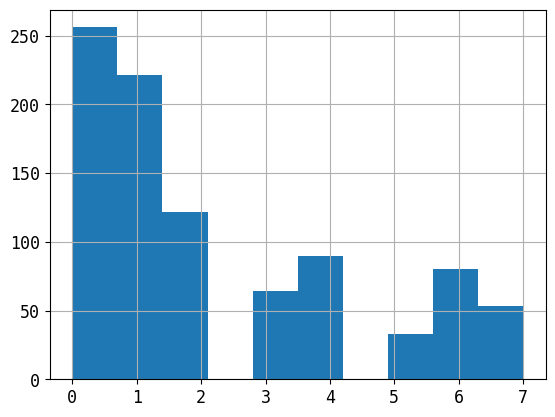

In [101]:
try:
    training_data.expression.hist()
except:
    training_data.expression_name.hist()

In [102]:
############################
## 200-fold down-sampled skew-normalized test
############################
sampleSize = 3 if test_on_custom_test_set else 500
acc_acc = []
f1_acc = []
for cycle in range(1,201):
    frames = []
    for i in range(0,8):
        frames.append(training_data[training_data.expression == i].sample(n=sampleSize, random_state=cycle).copy())
    tmp_downsampled_df = pd.concat(frames)

    y_true = np.array(tmp_downsampled_df['expression'].values.tolist())
    y_pred = np.array(tmp_downsampled_df['expression_hat'].values.tolist())

    acc_acc.append(ACC(y_true, y_pred))
    f1_acc.append(f1_score(y_true, y_pred, average='macro'))

m_200fold_top1 = np.mean(acc_acc)
m_200fold_f1 = np.mean(f1_acc)
    
print( "TOP-1 mean 200fold ACCURACY = %.5f" % np.mean(acc_acc))
print( "F-1 mean 200fold score = %.5f" % np.mean(f1_acc))

TOP-1 mean 200fold ACCURACY = 0.35750
F-1 mean 200fold score = 0.30591


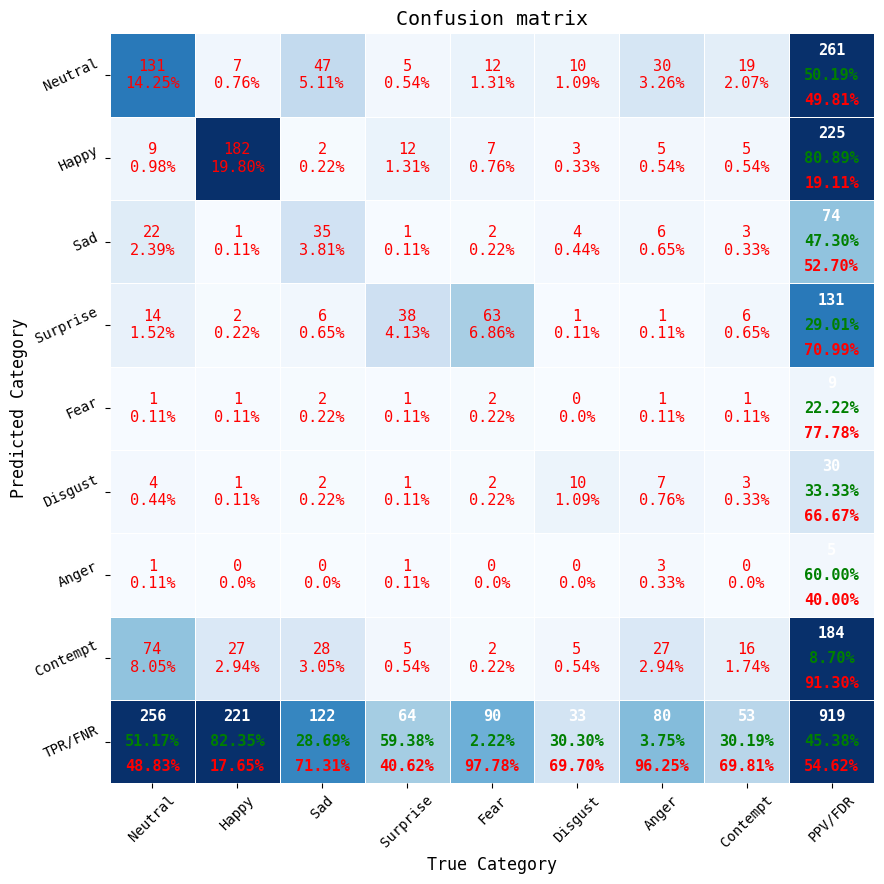

In [103]:
#################################
# FEW  MODEL CONFUSION MATRICES #
#################################
font = {
'family': 'monospace',
'size': 12
}
matplotlib.rc('font', **font)
y_true = training_data['expression'].values.tolist()
y_pred = training_data['expression_hat'].values.tolist()
mat = confusion_matrix(y_true, y_pred)

if(False):
    CMD = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=e_eval_8, )
    fig, ax = plt.subplots(figsize=(10,10))
    CMD.plot(ax=ax)

elif(False):
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(mat, annot=True, xticklabels=e_eval[:-1], yticklabels=e_eval[:-1], fmt=".0f", robust=True)#, norm=LogNorm())
    #ax.set(xlabel='Label', ylabel='Prediction', title="confusion matrix")
    plt.show()

elif(True):
    #
    # https://github.com/wcipriano/pretty-print-confusion-matrix
    #
    fig = plot_confusion_matrix_from_data(y_true, y_pred, columns=e_eval[:-1], cmap="Blues")
    fig.savefig("tests/"+test_name_w_underscores+"-conf_matrix.png", format="png", dpi=500)
else:
    display(mat)
    classes = e_eval_8
    accuracies = mat/mat.sum(1)
    fig, ax = plt.subplots(figsize=(10,8))
    cb = ax.imshow(accuracies, cmap='Greens')
    plt.xticks(range(len(classes)), classes,rotation=0)
    plt.yticks(range(len(classes)), classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            color='green' if accuracies[i,j] < 0.5 else 'white'
            ax.annotate(f'{mat[i,j]}', (i,j), 
                        color=color, va='center', ha='center')

    plt.colorbar(cb, ax=ax)
    plt.show()

N-RMSE: 0.304755 0.339198 0.321977


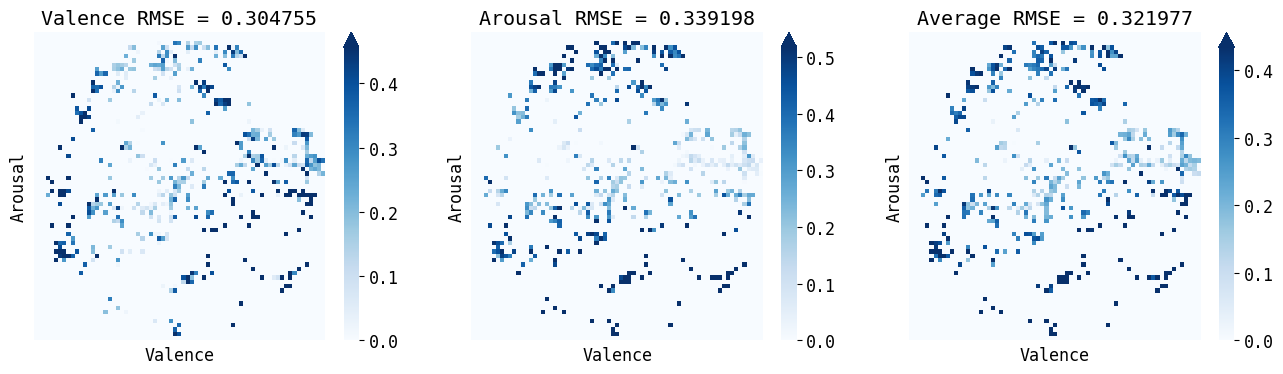

In [104]:
def rmse_boxes(df, _num_boxes=12, show_avg_rmse=False, annot=False):
    # calc boxes and init accumulators
    t = np.linspace(-1,1,_num_boxes+1)
    accumulator_val = []
    accumulator_aro = []

    # iterate over intervals in 2d
    for val_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
        inner_acc_val = []
        inner_acc_aro = []
        for aro_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
            
            # calculate valence and arousal rmse for points in 2d interval
            #display((val_int,aro_int))
            tmp = df[ (df.valence >= val_int[0]) & (df.valence <= val_int[1]) \
                    & (df.arousal >= aro_int[0]) & (df.arousal <= aro_int[1]) ]
            if( len(tmp.index) != 0 ):
                inner_acc_val.append(mean_squared_error(tmp.valence, tmp.valence_hat, squared = False))
                inner_acc_aro.append(mean_squared_error(tmp.arousal, tmp.arousal_hat, squared = False))
            else:
                inner_acc_val.append(0)
                inner_acc_aro.append(0)

        accumulator_val.append(inner_acc_val)
        accumulator_aro.append(inner_acc_aro)


    #display((accumulator_val, accumulator_aro))
    accumulator_val = np.array(accumulator_val)
    accumulator_aro = np.array(accumulator_aro)
    
    accumulator_val = np.rot90(accumulator_val, 1, (0, 1))
    accumulator_aro = np.rot90(accumulator_aro, 1, (0, 1))
    

    fig = plt.figure(figsize=(16,4))
    plt.subplot(131) if show_avg_rmse else plt.subplot(121)
    plt.title("Valence RMSE = %f" % np.mean(accumulator_val[accumulator_val != 0]))
    sns.heatmap(accumulator_val, cmap="Blues", robust=True, annot=annot, fmt=".2f",cbar_kws={'extend':'max'})
    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.subplot(132) if show_avg_rmse else plt.subplot(122)
    plt.title("Arousal RMSE = %f" % np.mean(accumulator_aro[accumulator_aro != 0]))
    sns.heatmap(accumulator_aro, cmap="Blues", robust=True, annot=annot, fmt=".2f",cbar_kws={'extend':'max'})
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    if (show_avg_rmse):
        plt.subplot(133)
        plt.title("Average RMSE = %f" % np.mean((accumulator_val + accumulator_aro)[(accumulator_val + accumulator_aro) != 0] /2))
        sns.heatmap((accumulator_val + accumulator_aro)/2, cmap="Blues", robust=True, annot=annot, fmt=".2f",
                   cbar_kws={'extend':'max'})
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.xlabel("Valence")
        plt.ylabel("Arousal")
    print("N-RMSE: %f %f %f"%(np.mean(accumulator_val[accumulator_val != 0]),np.mean(accumulator_aro[accumulator_aro != 0]),np.mean((accumulator_val + accumulator_aro)[(accumulator_val + accumulator_aro) != 0] /2)))
    return fig, np.mean(accumulator_val[accumulator_val != 0]), np.mean(accumulator_aro[accumulator_aro != 0]), np.mean((accumulator_val + accumulator_aro)[(accumulator_val + accumulator_aro) != 0] /2)
fig, norm_RMSE_val, norm_RMSE_aro, norm_RMSE_avg = rmse_boxes(training_data, 71, show_avg_rmse=True, annot=False)
fig.savefig("tests/"+test_name_w_underscores+"-rmse_boxes.png", dpi=500, format="png")

In [ ]:
#################################################################################
# GUI Visualizer for inspection of individual samples and their classifications #
#################################################################################
from PIL import Image

def inspect_data_hybrid(data, iterations):
    for _row_ in range(0,iterations):
        # Image selection
        test_col = data[_row_:_row_+1]
        data_dir = data_folder
        impath = data_dir  + [x for x in test_col[subdir_fp_column_name]][0],

        impath = impath[0]
        print(impath)
        # Fetching image data
        img = cv2.imread(str(impath))
        imS = cv2.resize(img, (512, 512))

        imPREDICT = cv2.resize(cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY),(__IN_DIM,__IN_DIM)) if __CHANNELS == 1 else cv2.resize(cv2.cvtColor(imS, cv2.COLOR_BGR2RGB),(__IN_DIM,__IN_DIM))#cv2.cvtColor(imS, cv2.COLOR_BGR2RGB)
        if(rescale_to_11_range):
            imPREDICT = imPREDICT / 127.5
            imPREDICT = imPREDICT - 1

        # Predictions
        if infer_onnx_ddamfn:
            img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(__IN_DIM,__IN_DIM)) if __CHANNELS == 1 else cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(__IN_DIM,__IN_DIM))#cv2.cvtColor(imS, cv2.COLOR_BGR2RGB)
            
            imPREDICT = (imPREDICT + 1) * 127.5
            # Define the mean and std
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])

            # Rescale the pixel values from [0, 255] to [0, 1] and other ...
            img = img / 255
            img = img - mean
            img = img / std
            img = img.astype(np.float32)
            img = img.transpose((2, 0, 1))[np.newaxis, :]
            
            predictions = sess.run(None, {input_name: img})
#             if(use_sig_entropy_loss):
#                 predictions[1][0] = (2 *( predictions[1][0] - 0.5))
            
            exp_array = np.exp(predictions[0][0])
            predictions[0][0] = exp_array / np.sum(exp_array)
        else:    
            predictions = loaded_model.predict(imPREDICT.reshape(1,__IN_DIM,__IN_DIM,__CHANNELS))
        
        predictedEmotion = int(np.argmax(predictions[0]))

        if(use_sig_entropy_loss):
            predictions[1][0] = (2 *( predictions[1][0] - 0.5))
        print(predictions[0][0])

        # Drawing
        imS = cv2.putText(imS, "Valence: %f | Arousal: %f | Category: %d" % \
                      (test_col.valence, test_col.arousal, test_col.expression), \
                      (20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)

        # Pad and pretty print
        imS = cv2.copyMakeBorder(imS, 100,300,50,350,cv2.BORDER_CONSTANT)
        imS = cv2.putText(imS, "Model evaluation:", (20,50), cv2.FONT_HERSHEY_SIMPLEX,
                      1, (25,225,225), 2, cv2.LINE_AA)

        imS = cv2.putText(imS, "Predicted emotion:", (300,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)
        imS = cv2.putText(imS, "%s" % (e_dict[predictedEmotion]),
                      (450 + getTextSize("%s" % (e_eval[predictedEmotion]), 0.5)[0]//2
                                      ,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)

        imS = cv2.putText(imS, "Annotated emotion:", (20,650), cv2.FONT_HERSHEY_SIMPLEX,
                      0.5, (25,225,225), 1, cv2.LINE_AA)
        imS = cv2.putText(imS, "%s" % (e_eval[int(test_col.expression.values[0])]),
                      (170 + getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 0.5)[0]//2
                                      ,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)




        drawVAgraph(imS, 20, 670, 200, test_col.valence.values[0], test_col.arousal.values[0],
                  predict_emotion = False, concat_axis_descriptions = True )

        drawVAgraph(imS, 300, 670, 200, predictions[1][0][0], predictions[1][0][1],
          predict_emotion = False, concat_axis_descriptions = True )



        imS = cv2.putText(imS, "annotation:",
                      (700,25),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)
        is_correct = predictedEmotion == test_col.expression.values[0]
        imS = cv2.putText(imS, "%s" % (e_eval[int(test_col.expression.values[0])]),
                      (750 - getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 2)[0]//2
                          ,60 + getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 2)[1]//2),
                      cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0) if is_correct else (255,0,0), 1, cv2.LINE_AA)

        _offset = 0
        for i in range(0,8):
            imS = cv2.putText(imS, "%s:" % (e_dict[i]), (600
                  ,110+_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)
            imS = draw_progress_bar(imS, 600,120+_offset,300,50,predictions[0][0][i])
            _offset += 90


        display(Image.fromarray(imS))


run_data_inspection = 200
if (run_data_inspection > 0):
    inspect_data_hybrid(training_data, run_data_inspection)


### Results

Store the results of the testing

In [106]:
metrics_fp = "tests/test_metrics.csv"

if not os.path.exists(metrics_fp):
    # Add results not created by me
    df_results = pd.DataFrame({
        "model": [
            'EfficientNet-B0 MODEL ON NIR AFFECTNET - Chen et al. (2022)',
            "DDAMFN MODEL ON VIS AFFECTNET - SOTA",
            "MOBILENET ON VIS AFFECTNET - AffectNet Test set",
            "MOBILENET ON VIS AFFECTNET - Custom160 Test set",
        ],
        "top-1-acc": [None,0.6475,0.62, 0.60625],
        "top-2-acc": [None, None, None, 0.77500],
        "top-3-acc": [None, None, None, 0.86875],
        "f1": [None,None,0.47, 0.54995],
        "val-rmse": [0.447,None,0.285,0.339658],
        "val-ccc": [0.527,None,0.822, 0.66519],
        "val-sagr": [None, None, None, 0.74375],
        "aro-rmse": [0.373,None,0.236, 0.399160],
        "aro-ccc": [0.426,None,0.598,0.47729],
        "aro-sagr": [None, None, None, 0.65000],
        "200fold-top1": [None, None, None,0.55425],
        "200fold-f1": [None, None, None,0.53701],
        "200fold-rmse_val": [None, None, None, None],
        "200fold-rmse_aro": [None, None, None, None],
        "200fold-rmse_avg": [None, None, None, None],
    })
    
    df_results.to_csv(metrics_fp, index=False)
    
df_results = pd.read_csv(metrics_fp)


new_row = [test_name,
           m_top1, m_top2, m_top3, m_f1, m_val_rmse, m_val_ccc, m_val_sagr,
           m_aro_rmse, m_aro_ccc, m_aro_sagr, m_200fold_top1, m_200fold_f1, norm_RMSE_val, norm_RMSE_aro, norm_RMSE_avg]

if test_name in df_results.model.tolist():
    index = df_results['model'].where(df_results['model'] == test_name).dropna().index[0]
else:
    index = len(df_results.index)

df_results.loc[index] = new_row
df_results.to_csv(metrics_fp, index=False)

In [107]:
index

30

In [108]:
# Set the display option so whole data is displayed
pd.set_option('display.max_colwidth', None)

In [109]:
df_results

,model,top-1-acc,top-2-acc,top-3-acc,f1,val-rmse,val-ccc,val-sagr,aro-rmse,aro-ccc,aro-sagr,200fold-top1,200fold-f1,200fold-rmse_val,200fold-rmse_aro,200fold-rmse_avg
0,EfficientNet-B0 MODEL ON NIR AFFECTNET - Chen et al. (2022),NaN,NaN,NaN,NaN,0.447000,0.527000,NaN,0.373000,0.426000,NaN,NaN,NaN,NaN,NaN,NaN
1,DDAMFN MODEL ON VIS AFFECTNET - SOTA,0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MOBILENET ON VIS AFFECTNET - AffectNet Test set,0.620000,NaN,NaN,0.470000,0.285000,0.822000,NaN,0.236000,0.598000,NaN,NaN,NaN,NaN,NaN,NaN
3,MOBILENET ON VIS AFFECTNET - Custom160 Test set,0.606250,0.775000,0.868750,0.549950,0.339658,0.665190,0.743750,0.399160,0.477290,0.650000,0.554250,0.537010,NaN,NaN,NaN
4,mobilenet_aff_nir-aff-16_unfrozen_lrs - AffectNet NIR Test set,0.629079,0.812009,0.902856,0.465451,0.377300,0.693325,0.752748,0.303130,0.403085,0.653743,0.585706,0.584891,NaN,NaN,NaN
5,mobilenet_aff_nir-aff-16_unfrozen_lrs - CustomDB Test set,0.408805,0.603774,0.754717,0.371355,0.359875,0.591034,0.710692,0.416286,0.316175,0.773585,0.418875,0.381058,NaN,NaN,NaN
6,mobilenet_aff_nir-oulu-bigger_split_strategy2-scheduler_from_5e-4 - AffectNet NIR Test set,0.547624,0.717178,0.820653,0.326857,0.406118,0.671190,0.748104,0.394134,0.193082,0.635410,0.397560,0.370385,NaN,NaN,NaN
7,mobilenet_aff_nir-aff-16_unfrozen_lrs - CustomDB with BUAA and OuluCasia Test set,0.504110,0.711720,0.835008,0.442579,0.312988,0.658831,0.631050,0.308597,0.361873,0.604262,0.473750,0.449747,NaN,NaN,NaN
8,mobilenet_combined - combined test set,0.536965,0.715953,0.840467,0.480223,0.381221,0.407235,0.571984,0.400925,0.155692,0.595331,0.492969,0.483999,NaN,NaN,NaN
9,mobilenet_combined - AffectNet NIR Test set,0.588378,0.783344,0.887932,0.399899,0.425904,0.516655,0.717926,0.348561,0.176415,0.626713,0.469110,0.454945,NaN,NaN,NaN


## Export

Exports to the onnx

In [65]:
if infer_onnx_ddamfn:
    print("Skipping ... Already in ONNX")
else:
    import tf2onnx

    onnx_model, _ = tf2onnx.convert.from_keras(loaded_model)

    # Save the ONNX model to disk
    with open("models/fer/"+fileName+".onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())

2024-05-08 07:15:16.261215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 07:15:16.261277: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-08 07:15:16.261414: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-08 07:15:16.261802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 07:15:16.261816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp